## 12.2 PGA memory leak

PGA Memory leak is seen with 12.2 database (at least on Solaris)
<code>
opatch lspatches
29770040;OCW JUL 2019 RELEASE UPDATE 12.2.0.1.190716 (29770040)
29757449;Database Jul 2019 Release Update : 12.2.0.1.190716 (29757449)


### OS: Active Logical Memory
column_label = 'Active Logical Memory, Kilobytes' from OEM sysman.MGMT$METRIC_DAILY

Temporary drop is OS patching restart

In [1]:
import pandas as pd
import sqlalchemy

sql_str=f'''
    SELECT rollup_timestamp, m.target_name, average/1024/1024 as gb
    FROM sysman.MGMT$METRIC_DAILY M
    WHERE 
    m.target_name in ('oraracprd03.ghc.org','oraracprd04.ghc.org')
    AND m.column_label = 'Active Logical Memory, Kilobytes'
    order by rollup_timestamp
'''
engine = sqlalchemy.create_engine(f'oracle+cx_oracle://@oemprd_13.3', arraysize=100, max_identifier_length=30)
df_os_data=pd.read_sql(sql_str, engine)
df_os_data['gb']=df_os_data['gb'].astype('float')


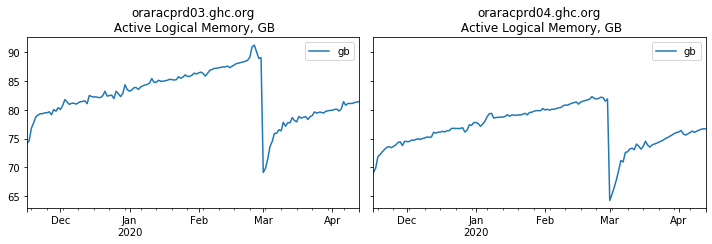

In [3]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(10,3.5),
                        sharey=True)
hosts=df_os_data.target_name.unique().tolist()
for (i,h) in enumerate(hosts):
    df=df_os_data.query('target_name==@h')
    df.plot(ax=axs[i], x='rollup_timestamp', y=['gb']).set_title(f'{h}\n Active Logical Memory, GB')
    axs[i].xaxis.label.set_visible(False)
    
fig.set_tight_layout(True)
fig.savefig('os_active_logical_memory.png', bbox_inches='tight')

### 'Total PGA Allocated' from dba_hist_sysmetric_summary

In [4]:
tnsname='fnipdup_12'

import pandas as pd
import sqlalchemy

sql_str=f'''
        SELECT to_char (round (end_time, 'hh24'), 'YYYY-MM-dd hh24:mi') snap_time
            ,i.host_name
            ,m.metric_name
            ,m.metric_unit
            ,m.maxval
            ,m.average
        FROM dba_hist_sysmetric_summary m, 
             gv$instance i 
        WHERE m.end_time >= current_timestamp - to_dsinterval('35 00:00:00')
              AND m.instance_number = i.instance_number
              AND m.metric_name = 'Total PGA Allocated'
        ORDER BY to_char (round (m.end_time, 'hh24'), 'YYYY-MM-dd hh24'), 
                 i.host_name, m.metric_name, m.metric_unit
'''
engine = sqlalchemy.create_engine(f'oracle+cx_oracle://@{tnsname}', arraysize=1000, max_identifier_length=30)
df_sys_data=pd.read_sql(sql_str, engine)
df_sys_data['snap_time']=pd.to_datetime(df_sys_data['snap_time'])

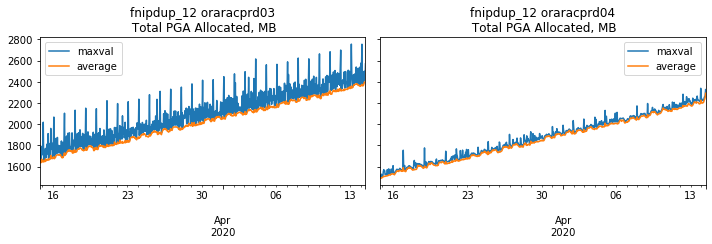

In [112]:
#df_sys_data.plot(x='snap_time', y=['maxval','average']).set_title(f'{tnsname}')
import matplotlib.pyplot as plt
pd.set_option('display.width', 120)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(10,3.5),
                        sharey=True)
                        #squeeze=0)
                        #sharex=True, sharey=False,
                        #dpi=100)#,constrained_layout=True)
hosts=df_sys_data.host_name.unique().tolist()
for (i,h) in enumerate(hosts):
    df=df_sys_data.query('host_name==@h')[['snap_time','maxval','average']]
    # convert bytes to MB:
    df1=df.apply(lambda x: x/1024/1024 if x.name in ('maxval','average') else x )
    df1.plot(ax=axs[i], x='snap_time', y=['maxval','average']).set_title(f'{tnsname} {h}\n Total PGA Allocated, MB')
    axs[i].xaxis.label.set_visible(False)
    
fig.set_tight_layout(True)
fig.savefig('total_pga_allocated_history.png', bbox_inches='tight')

### current snapshot of PGA memory consumers from gV$SESSMETRIC.pga_memory

In [21]:
sql_str=f'''
with v as
(select row_number() over (partition by sm.inst_id order by sm.pga_memory desc) as rn,
        s.program, sm.inst_id, sm.session_id, sm.pga_memory
from gV$SESSMETRIC sm, gv$session s
where sm.inst_id=s.inst_id and sm.session_id=s.sid and sm.serial_num=s.serial#
)
select
    case when rn <6 then rn else 6 end as rn,
    max(case when rn <6 then program else 'other' end) as program, 
    max(inst_id) as inst_id,
    max(case when rn <6 then session_id else 0 end) as sid,
    sum(pga_memory) as pga_memory
from v
group by inst_id, case when rn <6 then rn else 6 end
order by 3,1
'''
engine = sqlalchemy.create_engine(f'oracle+cx_oracle://@{tnsname}', max_identifier_length=30)
df_top_pga=pd.read_sql(sql_str, engine)

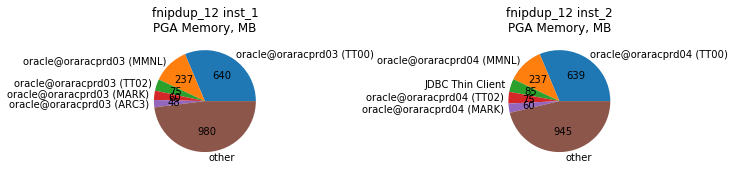

In [7]:
import matplotlib.pyplot as plt
pd.set_option('display.width', 120)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(10,2.5))
                        #sharey=True)
                        #squeeze=0)
                        #sharex=True, sharey=False,
                        #dpi=100)#,constrained_layout=True)

for i in range(2):
    inst=i+1
    df=df_top_pga.query('inst_id==@inst')[['program','pga_memory']].set_index('program')
    total=df.loc[:,'pga_memory'].sum()
    
    ax=df.plot.pie(ax=axs[i], y='pga_memory', 
                   autopct=lambda p: '{:.0f}'.format(p * total / 100 / 1024/1024),
                  legend=None)
    ax.axis('off') # supress side label
    ax.set_title(f'{tnsname} inst_{inst}\nPGA Memory, MB')
    #l=ax.legend(loc='center',bbox_to_anchor=(-0.2, 0))
   
fig.set_tight_layout(True)
fig.savefig('total_pga_allocated_current_snapshot.png', bbox_inches='tight')

### PGA history from DBA_HIST_ACTIVE_SESS_HISTORY.pga_allocated
Note that this has only active sessions. Inactive sessions will not be there.

This may explain why MMNL is not listed and why combined PGA size looks lower than above.

Unfortunatley dba_hist_sessmetric_summary is empty and therefore can not be used.

In [124]:
sql_str=f'''
select  trunc(sample_time, 'HH24') as sample_time, 
        instance_number, 
        program, 
        avg(pga_allocated)/1024/1024 as pga_allocated_mb
from DBA_HIST_ACTIVE_SESS_HISTORY 
where sample_time > sysdate - 35
group by trunc(sample_time, 'HH24'), instance_number, program
order by 1,2
'''
engine = sqlalchemy.create_engine(f'oracle+cx_oracle://@{tnsname}', arraysize=1000, max_identifier_length=30)
df_ses_data=pd.read_sql(sql_str, engine)
df_ses_data['sample_time']=pd.to_datetime(df_ses_data['sample_time'])
#df_ses_data

In [125]:
# replace program with "other" when not a top program
def replace_program(row, inst):
    if row['instance_number']!=inst:
        return row['program']
    else:
        if row['program'] in top_prog_list:
            return row['program']
        else:
            return 'other'

for i in range(2):
    inst=i+1
    top_prog_list=df_top_pga.query('inst_id==@inst').program.unique().tolist()
    df_ses_data['program']=df_ses_data.apply(replace_program, axis=1,args=(inst,) )

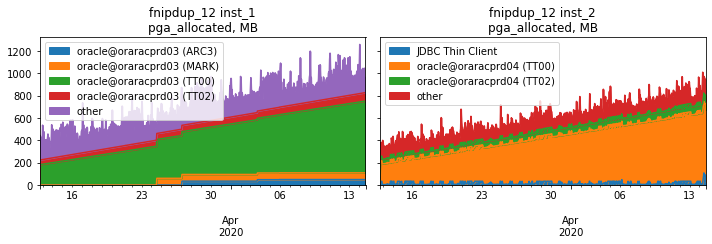

In [127]:
import numpy as np

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,3.5),sharey=True)

for i in range(2):
    inst=i+1
    df_pivot=df_ses_data.query('instance_number==@inst')\
              .pivot_table(index='sample_time', columns='program', values='pga_allocated_mb', aggfunc=np.sum) \
              .fillna(method='ffill').fillna(0)
    df_pivot.columns=df_pivot.columns.tolist()
    #d=df_pivot.groupby(by=lambda t: t.replace(hour=0, minute=0, second=0, microsecond=0)).mean()
    #d1=d.apply(lambda x: x/1024/1024)
    df_pivot.plot.area(ax=axs[i],stacked=True).set_title(f'{tnsname} inst_{inst}\npga_allocated, MB')
    axs[i].xaxis.label.set_visible(False)
    
fig.set_tight_layout(True)
fig.savefig('pga_allocated_active_sessions.png', bbox_inches='tight')